In [1]:
sys.path.append('../..')
import ugent

In [2]:
def T(alpha, t):
    cy = 1/sin(alpha)
    # beta = asin(t * sin(pi/2 - alpha))
    beta = t * alpha
    r = cot(alpha)
    return (r*sin(beta), cy - r*cos(beta))

/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


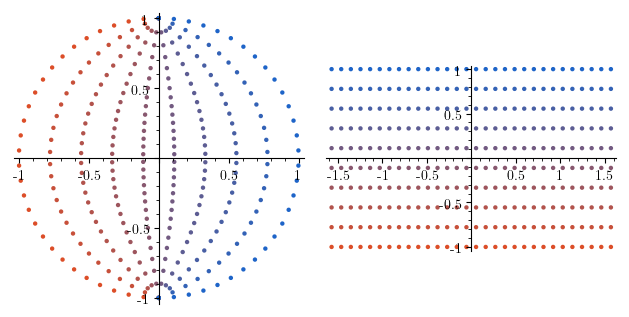

In [3]:
import matplotlib.pyplot as plt
import string
import numpy as np
import matplotlib as mpl

mpl.rc('font', family='serif', size=10, serif="Computer Modern Roman")
mpl.rc('text', usetex=True)

alphas = np.linspace(float(-pi/2), float(pi/2), 30)
ts = np.linspace(-1, 1, 10)

gt = Graphics()
go = Graphics()
for i, t in enumerate(ts):
    c = Color.blend(Color(ugent.rood), Color(ugent.blauw), i/(len(ts)-1))
    gt += list_plot([T(alpha, t) for alpha in alphas], color=c)
    go += list_plot([(alpha, t) for alpha in alphas], color=c)

base = 0.6
kwt = dict(aspect_ratio=1, figsize=(5*base,4*base))
kwo = dict(aspect_ratio=1, figsize=(5*base,4*base))

graphics_array([gt, go]).show(aspect_ratio=1)

# gt.save("disc_transformed.pdf", **kwt)
# go.save("disc_original.pdf", **kwo)

In [4]:
var('alpha, t')
sT = vector(SR, T(alpha,t))
sTa = diff(sT, alpha)
sTt = diff(sT, t)
sTaa = diff(sTa, alpha)
sTat = diff(sTa, t)
sTtt = diff(sTt, t)

ua, va = sTa
ut, vt = sTt
uaa, vaa = sTaa
uat, vat = sTat
utt, vtt = sTtt

cs = (matrix([
        [ua, va, 0, 0, 0],
        [ut, vt, 0, 0, 0],
        [uaa, vaa, ua*ua, 2*ua*va, va*va],
        [uat, vat, ua*ut, (ut*va+ua*vt), va*vt],
        [utt, vtt, ut*ut, 2*ut*vt, vt*vt]
]).solve_left(vector([0,0,1,0,1]))).simplify_full()

cs = [fast_callable(c, vars=(alpha, t), domain=float) for c in cs]

In [5]:
import numpy as np
import scipy.linalg as scl
import scipy.sparse as scs
import scipy.sparse.linalg as scsl

na = 51
nt = 51

assert na%2 == 1

alphas = np.linspace(float(-pi/2), float(pi/2), na+1)
ha = float(alphas[1] - alphas[0])

indices = [(int(i), int(j)) for j in range(1, nt) for i in range(1, na)]

def tridiag(abc, n):
    a, b, c = abc
    return matrix.toeplitz([b, a] + [0]*(n-2), [c] + [0]*(n-2), ring=RDF).numpy(dtype="float")

def D1(n):
    return tridiag((-1, 0, 1), n)

def D2(n):
    return tridiag((1, -2, 1), n)

def I(n):
    return np.eye(n, dtype="float")

def k(A, B):
    return np.kron(A, B)

Ma = k(I(nt-1), D1(na-1))/float(2*ha)
Mt = k(D1(nt-1), I(na-1))/float(2)
Maa = k(I(nt-1), D2(na-1))/float(ha*ha)
Mat = k(I(nt-1), D1(na-1)) @ k(D1(nt-1), I(na-1))/float(4*ha)
Mtt = k(D2(nt-1), I(na-1))

def matrix_problem(epsilon):
    ts = np.linspace(-1, float(2*epsilon-1), nt+1)
    ht = float(ts[1] - ts[0])

    def C(k):
        v = np.ndarray((len(indices),), dtype="float")
        for l, (i, j) in enumerate(indices):
            v[l] = cs[k](alphas[i], ts[j])
        return v
    
    M = np.multiply(C(4)[:,None], Mtt)
    M /= ht
    M += np.multiply(C(1)[:,None], Mt)
    M += np.multiply(C(3)[:,None], Mat)
    M /= ht
    M += np.multiply(C(0)[:,None], Ma)
    M += np.multiply(C(2)[:,None], Maa)
    M *= -1
    
    return M

def band_eigenvalues(M, n, **kwargs):
    # M should be symmetric
    B = np.zeros((n, M.shape[0]), dtype="float")
    for i in range(n):
        B[-1-i, i:] = np.diagonal(M, i)
    return scl.eigvals_banded(B, **kwargs)
    

In [6]:
def solve_problem(epsilon):
    M = matrix_problem(epsilon)
    return sorted(np.real(scsl.eigs(scs.dia_matrix(M), k = 20, sigma=float(0), return_eigenvectors=False)))

In [7]:
from pqdm.processes import pqdm

epsilons = np.linspace(0.01, 1, 200)
solutions = pqdm(epsilons, solve_problem, n_jobs=8)

SUBMITTING | : 100%|██████████| 200/200 [00:00<00:00, 2807.71it/s]
PROCESSING | : 100%|██████████| 200/200 [00:36<00:00,  5.53it/s]
COLLECTING | : 100%|██████████| 200/200 [00:00<00:00, 480998.17it/s]


In [32]:
from scipy import special as sc

exact = []
for i in range(100):
    zeros = sc.jn_zeros(i, 10)
    zeros **= 2
    if zeros[0] > 100:
        break
    assert zeros[-1] > 100
    for z in zeros:
        if z > 100:
            break
        exact.append((z, 1 if i == 0 else 2))
exact.sort()

/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


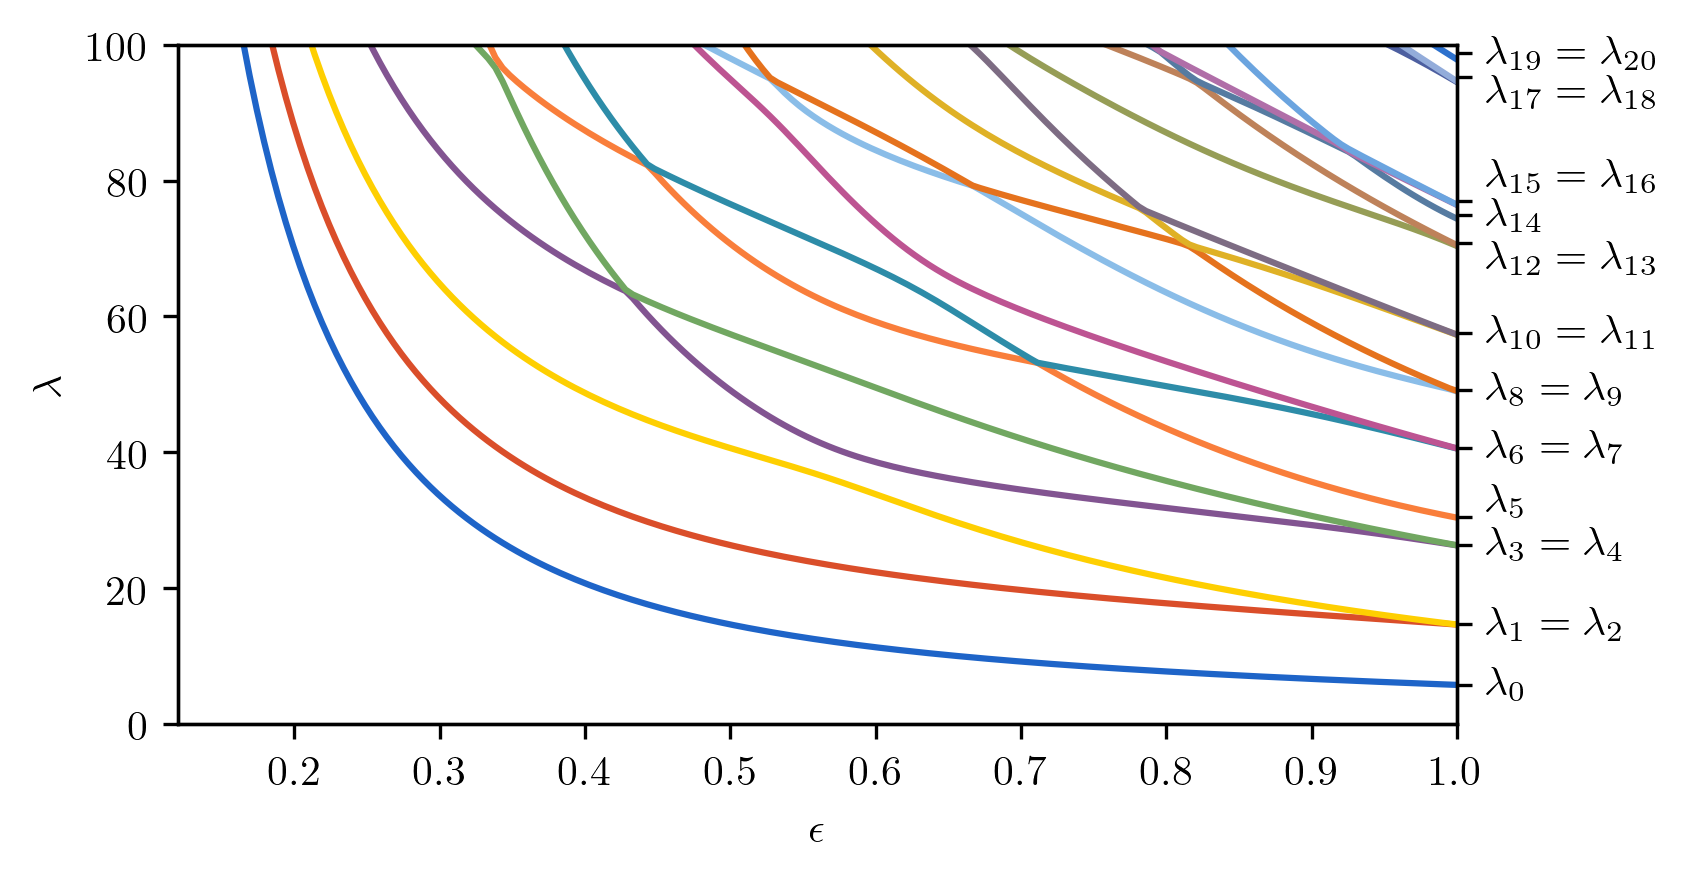

In [42]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5.5,3), dpi=300)
for kleur, (i, v) in zip(ugent.palet, enumerate(list(zip(*solutions)))):
    plt.plot(epsilons, v, color=kleur)
plt.ylim(0,100)
plt.xlim(0.12, 1)

ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())

ticks = []
labels = []

k = 0
for e, m in exact:
    ticks.append(e)
    labels.append(f"$\\lambda_{{{k}}}$"  if m == 1 else f"$\\lambda_{{{k}}} = \\lambda_{{{k+1}}}$")
    k += m
    
ax2.set_yticks(ticks)
ax2.set_yticklabels(labels)
ax2.get_yticklabels()[3].set_verticalalignment("baseline")
ax2.get_yticklabels()[7].set_verticalalignment("top")
ax2.get_yticklabels()[9].set_verticalalignment("bottom")
ax2.get_yticklabels()[10].set_verticalalignment("top")

ax1.set_xlabel("$\\epsilon$")
ax1.set_ylabel("$\\lambda$")
# plt.savefig("eigenvalues_flow.pdf", bbox_inches="tight")

None

array([ 3.83170597,  7.01558667, 10.17346814, 13.32369194, 16.47063005,
       19.61585851, 22.76008438, 25.90367209, 29.04682853, 32.18967991])

In [9]:
solutions[-1][0::2]

[5.780438986652241,
 14.669180196973153,
 26.33159922683086,
 40.56909961093695,
 48.97814799109589,
 57.30323436776522,
 70.37431502592479,
 74.39776016395096,
 76.45550052460509,
 94.61743922707454]

verbose 0 (3797: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 200 points.
verbose 0 (3797: plot.py, generate_plot_points) Last error message: 'jacobi() missing 1 required positional argument: 'm''


/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


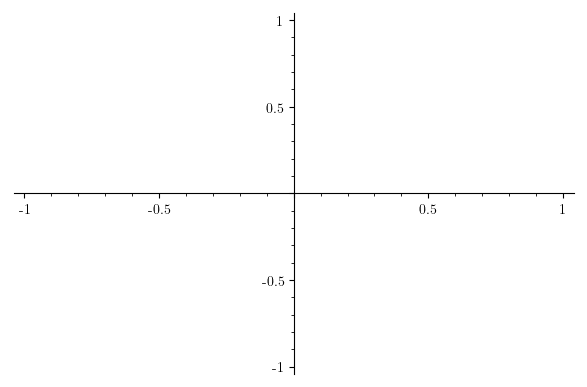

In [12]:
plot(lambda x: jacobi(x, 3), 0, 100)

/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


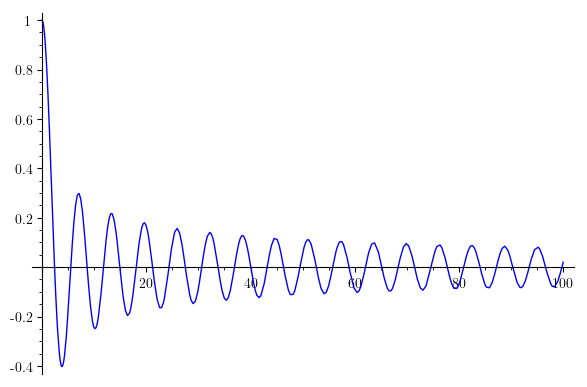

In [22]:
plot(lambda x: bessel_J(0, x), (0, 100))